# Gradient descent and backpropagation

- Part 2.1: With the same neural network from last week, understand how stochastic gradient descent is implemented.
- Part 2.2: Do pen and paper calculations of backpropagation

In [2]:
%matplotlib inline

import numpy as np
import random
import matplotlib.pylab as plt
from scipy.interpolate import interp1d

## Exercises

### Part 2.1: Understanding SGD

Let's reuse Michael Nielsen's neural network from last session. Some new question are inserted in the comments (they start with "Q: "). Michael uses [list comprehensions](https://www.w3schools.com/python/python_lists_comprehension.asp) a lot, so make sure to learn that syntax.

In [3]:
# Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

def step(z, threshold=0.5):
    if z > threshold:
        return 1
    return 0

# Feed forward neural network class
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, lr, test_data=None, silent=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        n = len(training_data)
        if test_data:
            n_test = len(test_data)
        
        for j in range(epochs):
            
            # Q1: What happens here? Explain the contents of `mini_batches`.
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            
            # Q2: And what does this step do?
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lr)
            
            if not silent:
                if test_data:
                    print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
                else:
                    print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, lr):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``lr``
        is the learning rate."""
        
        # These two vectors correspond to -∇C(W) (and -∇C(b))
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # Q3: How does this code work to update `nabla_b` and `nabla_w`
        for x, y in mini_batch:
            nabla_b_i, nabla_w_i = self.backprop(x, y)
            nabla_b = [nb+nb_i for nb, nb_i in zip(nabla_b, nabla_b_i)]
            nabla_w = [nw+nw_i for nw, nw_i in zip(nabla_w, nabla_w_i)]
            
        # Q4: Now we have our gradient vectors, `nabla_b` and `nabla_w`. Explain how we use them
        # to update the weights and biases
        self.weights = [
            w - lr * nw / len(mini_batch)
            for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - lr * nb / len(mini_batch)
            for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # In backprop, we first do a feed forward step. We store all the
        # intermediate values that get computed. This is because, when we
        # compute the gradient on a weight, we ask how changing it a little
        # might influence the value that gets computed with it. Hence we need
        # to store these values.
        
        # Feedforward # 
        # ----------- #
        
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        
        # Backward pass # 
        # ------------- #
        
        # Q5: What does the variable `delta` store here? Why is the last bias
        # gradient exactly `delta`?
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        
        # Q6: Seems like we are multiplying each of the outputs from the previous
        # layer, with the delta. Can you explain why we do this? 
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book. Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on. It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        
        # Q7: What does this loop do?
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
            
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if self.sizes[-1] == 1:
            test_results = [
                (step(self.feedforward(x)), y)
                for x, y in test_data
            ]
        else:
            test_results = [
                (np.argmax(self.feedforward(x)), y)
                for x, y in test_data
            ]
        return sum(int(y_pred == y) for (y_pred, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives dC_x/da
        for the output activations."""
        return output_activations - y


> **Ex. 2.1.1** Draw a overview illustrating which method depend on which method in the `Network` class. Below, give a short explanation as to what each method does.
>
> *Hint*: You can draw by hand take a picture and put it into the notebook, work your paint skills, make ascii art or whatever your inner creative finds easiest. Just as long as one can somehow read the relations in your answer.

# 1) Cost_Derivative
cost_derivative method returns the vector of partial derivatives, in order to determine the new output activations. Essentially returning the output activations - y. 
# 2) Backprop
the backprop method utelizes the cost_derivative method and returns a tuple of two numpy arrays, similar to the biases and weights necessary to compute the backpropogation. It does a forward pass to store all activations followed by a backwards pass to determine the new values of biases and weights. This ultimately returns the updated weight and biase values that reduce the loss for the network.
# 3) Feedforward
the feedforward method performs a forward pass on the network and returns the prediction of the network for a certain value input.
# 4) Update mini batch
the update_mini_batch method updates the network's weights and biases based on the gradients computed from the mini-batch.
# 5 Evaluate
Evalute returns the number of correctly predicted examples in the data, essentially assessing the networks performance on a given dataset. 
# 6  SGD
SGD trains the network on the training data using stochastic gradient descent to minimize the loss. 
# 7) Sigmoid
Sigmoid and Sigmoid prime implement the sigmoid activation function and its derivative.

![netilusstration](https://github.com/daisy-abbott/NeuralNets/assets/112681549/3150aff3-9491-407b-a9e3-9a0450112853)

> **Ex. 2.1.2** Answer questions Q1-4 in the code. Write / code down the answer to each one of them in cells below.
>
> *Hint*: You need to closely follow the code. You can verify that your idea of what a variable contains is correct, if you print it. Simply create an instance of the network and you will be able to access the variables of that instance to see what they look like. Example:
>
>     net = Network([2, 3, 1])
>     net.biases  # this gets you the biases property of the network

## Answer to Q1

Inside the first for loop (for j), the training data is randomly shuffled as to not bias the network to learn in a particular way. Next, mini_batches is created from the training data by selecting slices from the training data with a size of mini_batch_size. Then the network loops from 0 to n iterations (the entirety of the training data) in steps of mini_batch_size. Each mini batch is a subset of the training data that will be used for updating the weights of the network. 

# Answer to Q2
This section of code iterates over each mini batch generated by the previous code. For each mini batch, it calls the update_mini_batch method of the neural network, passing in the mini-batch and the learning rate. The update_mini_batch method then performs the backpropagation and weight/bias updates based on the gradients computed from the mini-batch.


# Answer to Q3
Here, we iterate through each training example (x, y) in the mini batch. Then we backpropagate through the network storing the adjustments that should be made to these weights/biases in nabla_b and nabla_w. 


# Answer to Q4: 
Next, we update the weights and biases by subtracting the gradients calculated in the backpropagation from the current weight. This process minimizes the loss and makes sure that the network is trained to make more accurate predictions. 
  

### Part 3.1: Backpropagation

**Your understanding** of neural networks should now be something along the lines of: (1) a datapoint propagates forward through the network, then (2) a cost (how bad the prediction is) is evaluated and its gradient wrt. each weight is computed, and finally (3) the weights are updated according to how much they influence the cost.

However, something important is missing from our understanding at this point. Remember, that *gradient descent* – the algorithm for minimizing the cost function, which we can think of as ball rolling downhill – needs to known which direction is downhill on the cost function. The gradient tells us this. **So how do we compute the cost function's gradient?** Enter: *backpropagation*. Backpropagation is an algorithm which computes the gradient of the cost function wrt. each weight in the network, from end to start, by iteratively applying *the chain rule*. It is called *back*-propagation because it computes gradients from front to back.

#### Pen and paper calculations

First, do some pen and paper calculations to hand-compute gradients in a real neural network.

##### ![img](https://raw.githubusercontent.com/abjer/tsds/master/material_exercises/week_3/2_3_1_net.png)

> **Ex. 2.2.1**: The network above has a defined input and weights. If the true label for the datapoint `[4, 2]` is 1, what is the cost?

In [4]:
0.0812

0.0812

> **Ex. 2.2.2**: Knowing about backpropagation, we actually have everything we need to compute the gradients of the weights by hand. So go ahead and do that. Report your answer either as a diagram that includes the gradients (you can draw on my figure somehow and insert the resulting image), or just by writing what the gradient of each weight is.
>
> *Hint*: When computing gradients with backprop, it can be helpful to think of the network as a [computational graph](https://github.com/abjer/tsds/blob/master/material_exercises/week_3/2_3_1_net_compgraph.png?raw=true).
>
> *Hint*: Some of the gradients will become *very* small, known as the vanishing gradient problem. If they get smaller than 1e-4 you can just set them to zero.*
>
> *Note*: If you show me which equations you used and what your process is, I can give better feedback in case there are mistakes.

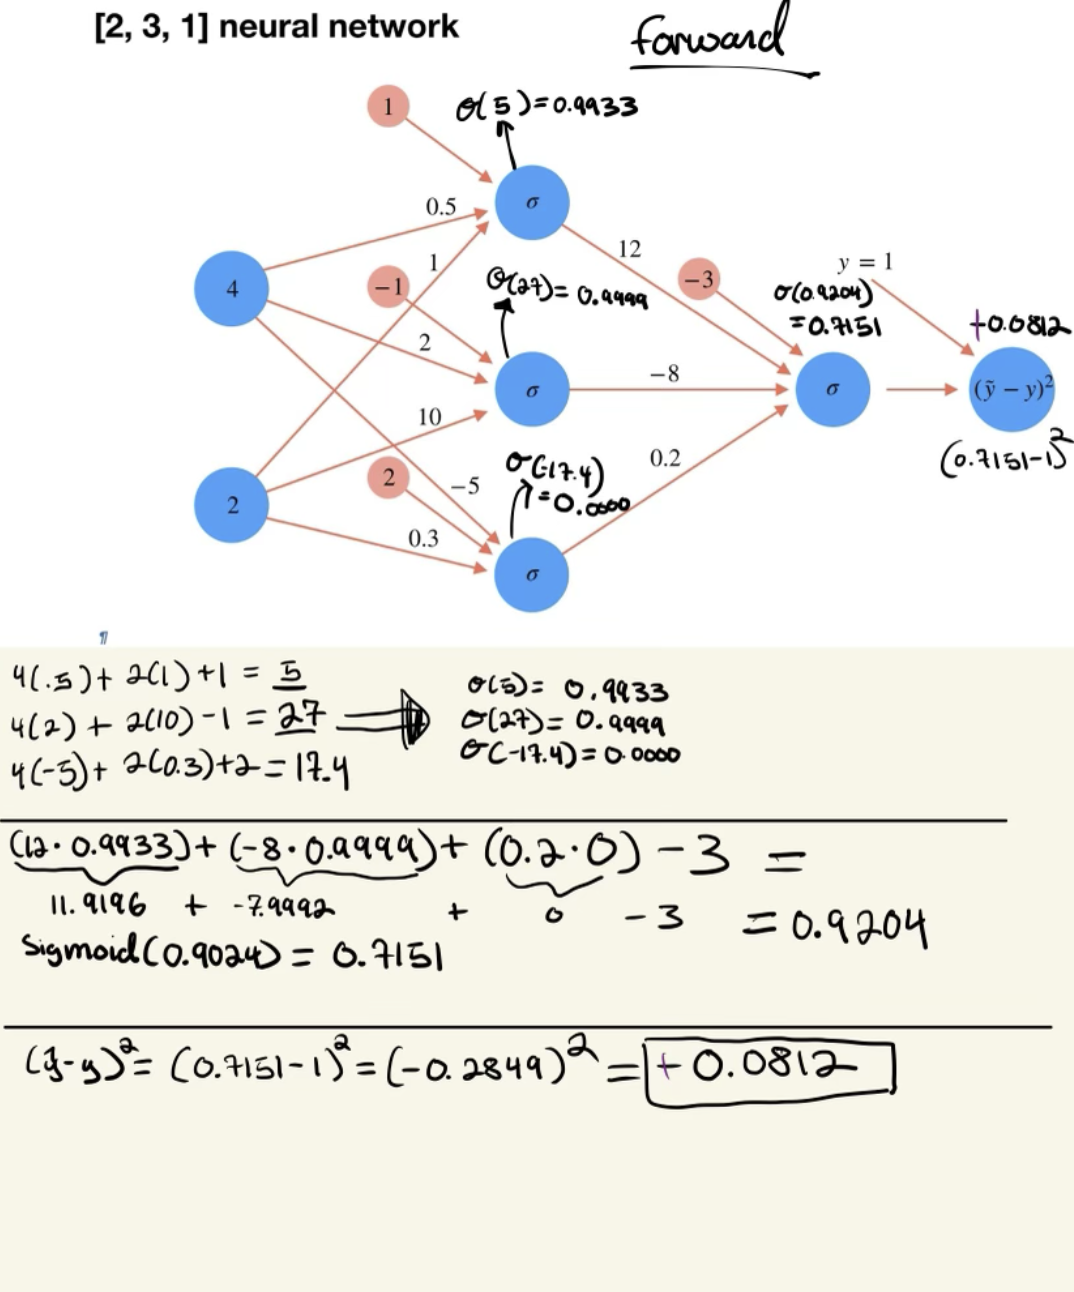

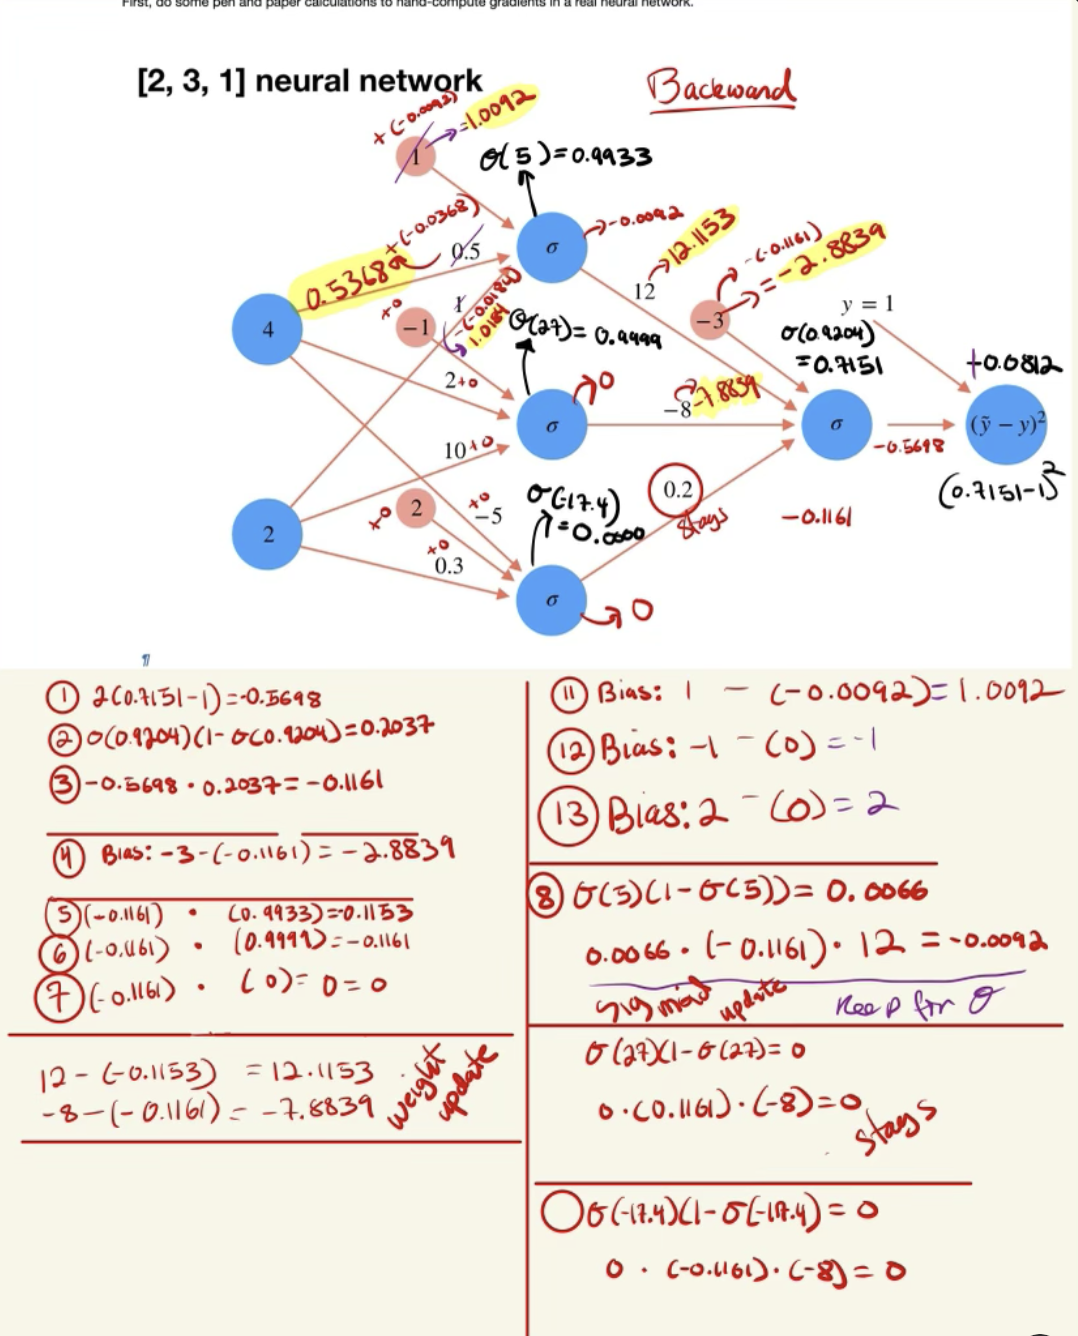

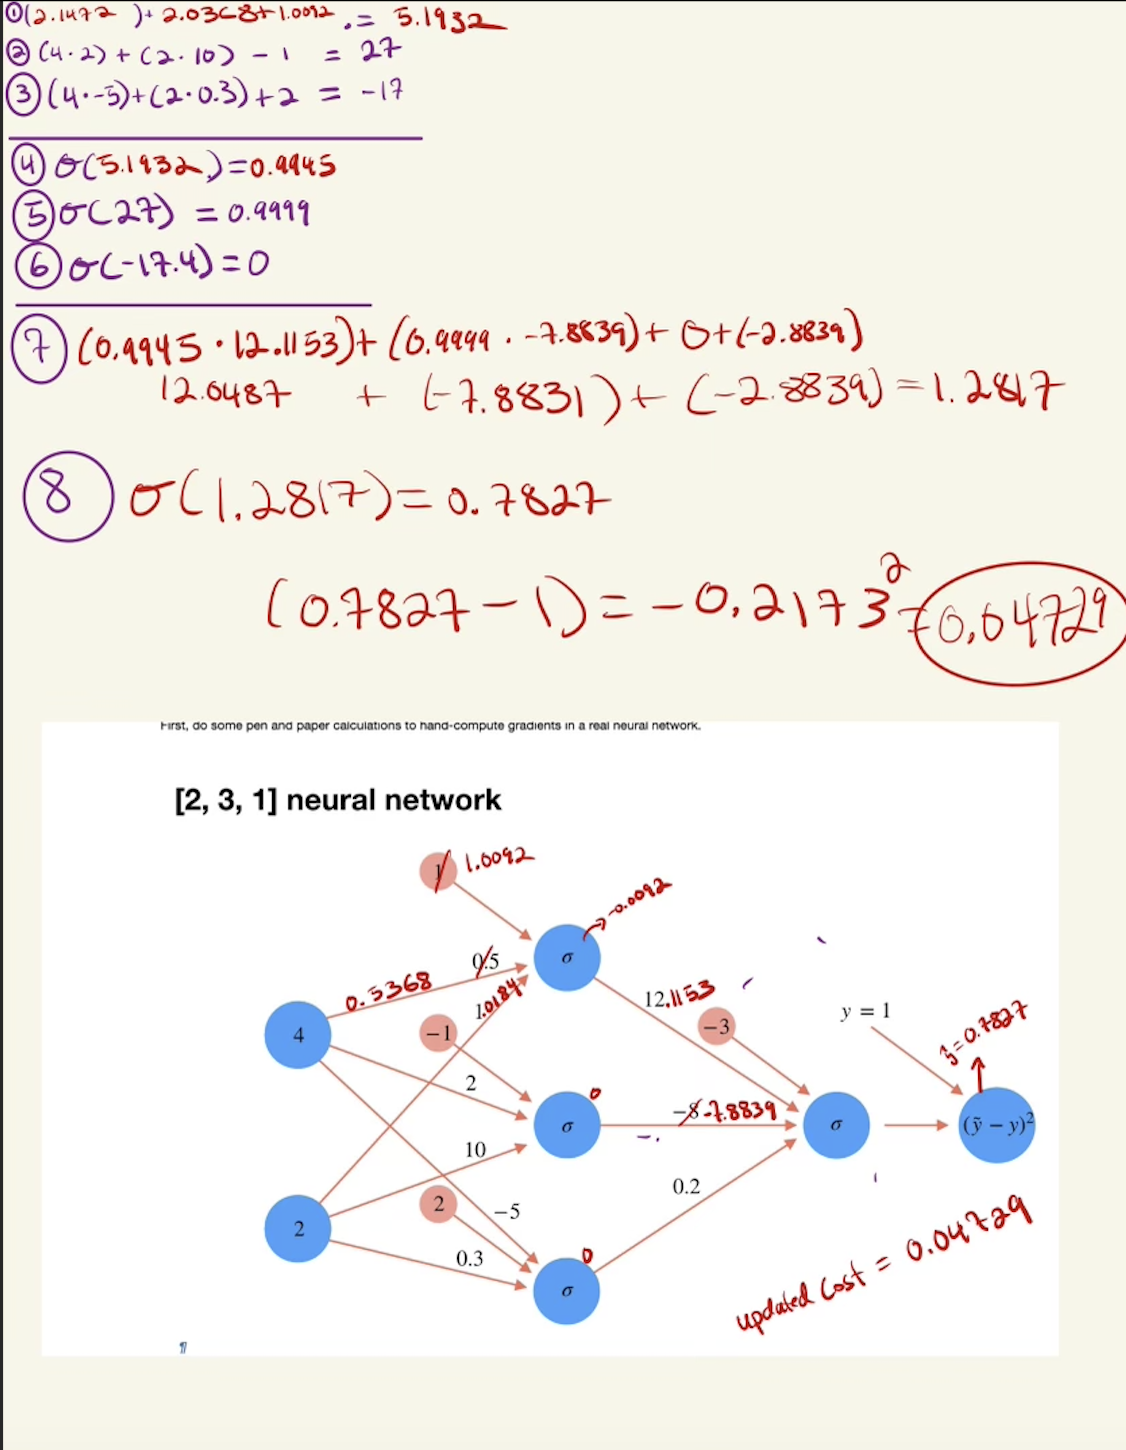

> **Ex. 2.2.3:** Provide answers to the code questions Q5-7.
>
>*Note:* `Q7` relies on having a solid grasp of the backpropagation equations (BP1-4) of Micheal Nielsens book. These cast what we learned today in vector notation, using matrix multiplication to compute the gradients of *vectors and matrices of weights*. You are not required to know these equations - the important thing is that you grasp the key ideas of backpropagation.



# Q5 
The variable delta stores the error in the output layer of the network. The last bias gradient is updated 
to equal delta because the derivative of the cost function with respect to the bias in the final layer is 
the same as the error. This is because of the chain rule. 

# Q6 
Multiplying the outputs from the previous layer with delta helps figure out how much each connection contributed to the networks' error. The dot product then combines delta with the output to make adjustments to the connections and reduce overall prediction errors during training.

# Q7 
The loop iterates through the network backwards, exlcuding the input layer and stopping before reaching the output layer. Each iteration, it computes the error (or delta) for the current layer, updates the bias (nabla_b), and computes the weight gradient (nable_w). It essentially does the backpropagation, adjusting errors backward through the layers to compute gradients for weight and bias updates.